In [1]:
import Diagrams.Prelude hiding (normal, Measure)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict
import qualified Control.Monad.Bayes.Sampler.Lazy as L
import Control.Monad.Bayes.Traced.Static
import Control.Monad.Bayes.Inference.MCMC
import Numeric.Log
import qualified Diagrams.Backend.Cairo as C
import Control.Monad
import qualified Control.Monad.Bayes.Weighted as Weighted
import Control.Monad.Bayes.Density.Free
import Control.Monad.Writer
import Control.Monad.Loops

{-# LANGUAGE NoMonomorphismRestriction #-}
{-# LANGUAGE FlexibleContexts          #-}
{-# LANGUAGE TypeFamilies              #-}

<!-- ideas:

sample from the space of linear maps, and apply to a square

show wigner semicircle distribution -->

`Diagram`s, from the `diagrams` package, are representations of 2D diagrams, which can be displayed using a variety of backends. In the spirit of Haskell, `Diagram`s  compose in a variety of ways, so to create a complex diagrams, you build it up from simpler parts.

Because `Diagram`s are first class values in Haskell, we can define distributions over them

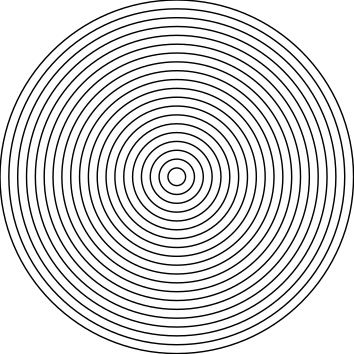

In [2]:
circles n = do 
    x <- bernoulli 0.01
    if x then return $ mconcat (circle <$> [1..n]) else circles (n + 1)
    
sampleIOfixed (diagram <$> circles 1)

## Viewing traces

A nice use of diagrams is to view probabilistic program execution traces. Given a `program :: MonadMeasure m => m X`, we can convert it into a sampler of traces and their weights using `getTrace` defined below:

In [3]:
getTrace :: Weighted (Density SamplerIO) a -> SamplerIO ([Double], Log Double)
getTrace m = fmap (\((x,y),z) -> (z,y) ) $ runWriterT $ weighted $ Weighted.hoist (WriterT . density []) m

In [4]:
program = do
    x <- beta 1 2
    b <- Control.Monad.Bayes.Class.normal (x**2) 1
    factor $ normalPdf 0 ( abs b) x
    return b

In [5]:
traceDiagram :: ([Double], Log Double) -> Diagram C.B
traceDiagram (trace, weight) = fromVertices [p2 (i,y) | (y,i) <- zip trace [1..]] # opacity (ln $ exp weight) # scaleX 1


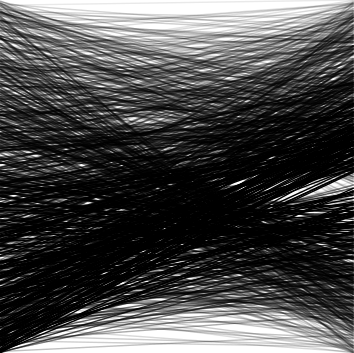

In [6]:
sampleIOfixed $ fmap (diagram . mconcat . fmap traceDiagram) $ replicateM 1000 $ getTrace program

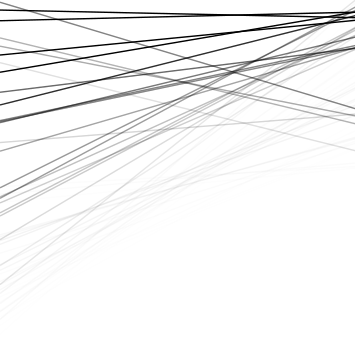

In [7]:
program :: Measure Double
program = do
    x <- random
    y <- normal 0 (x**2)
    factor (Exp $ log y)
    return y

sampleIOfixed $ fmap (diagram . mconcat . fmap traceDiagram) $ replicateM 100 $ getTrace program


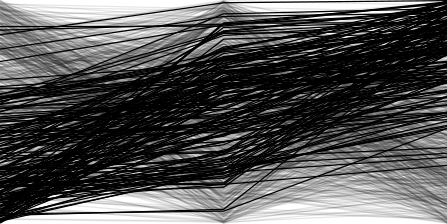

In [8]:
import Data.List (sort)

program :: Measure ()
program = do
    xs <- replicateM 3 random
    factor $ if xs == sort xs then 1 else 0.1

sampleIOfixed $ fmap (diagram . mconcat . fmap traceDiagram) $ replicateM 1000 $ getTrace program


# Displaying random walks

Another nice use of `diagrams` is to produce a distribution over a random walk, and then convert it into a distribution over diagrams of random walks:

In [9]:
import qualified Control.Monad.Bayes.Sampler.Lazy as Lazy

In [10]:
kernel :: MonadDistribution m => V2 Double -> m (V2 Double)
kernel (V2 x y) = do
    newX <- normal x 0.01
    newY <- normal y 0.01
    return (V2 newX newY)

randomWalk :: Distribution [V2 Double]
randomWalk = unfoldrM (fmap (Just . (\x -> (x,x))) . kernel) 0

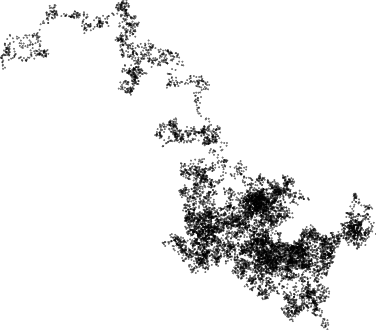

In [11]:
convertPointToDiagram :: V2 Double -> Diagram C.B
convertPointToDiagram point = circle 0.001 # translate point

convertListofNPointsToDiagram :: Int -> [V2 Double] -> Diagram C.B
convertListofNPointsToDiagram n = mconcat . take n . fmap convertPointToDiagram

diagramList :: Distribution (Diagram C.B)
diagramList = fmap (convertListofNPointsToDiagram 10000) randomWalk

d <- L.sampler diagramList
diagram d